**A little background** :
After recording the electric fields and the magnetic fields at the surface, we process them and estimate the transfer function in frequency domain. These transfer functions are complex qunatities and we split them into amplitude (called apparent resistivity in the MT community) and phase. Therefore, at any station, we have apparent resistivity $\rho_a$ and phase $\phi$ observed at different frequencies.
As an eg., if we have the data at 50 different frequencies, we have $\rho_a$ as a 50-element vector and the same for $\phi$. We combine them to form
$$
y = [\rho_a \quad \phi]
$$



Without going into the derivation, this data is observed for a particular conductivity structure $x$. We can solve the governing PDEs to obtain the above transfer functions. Fortunately, in 1D we have a sort of an analytical soln and it's easy to do the following mapping:
$$
F : x \rightarrow y
$$

We want to solve the inverse problem, that is, for a given realization of data $y_{obs}$, we want to infer $x$. This inverse problem is ill-posed and suffers from non-uniqueness. For the sake of completeness, we solve the following optimization problem:
$$
\underset{x}{\operatorname{argmin}} \; |(y_{obs} - F(x))|_2^2 + \mu L|x|_2^2
$$
where $L$ is usually the derivative matrix.

The Bayesian perspective is to obtain the posterior :
$$
p(x|y_{obs}) \propto p(y_{obs}|x) p(x)
$$

This is our objective : obtaining the posterior on $x$.

**Generative AI** :
One objective of generative modeling frameworks (GANs, Normalizing Flows, VAEs, Diffusion models) is to learn a distribution and generate samples from it. An example of generative models would be to learn a distribution of cat images and generate another image of a cat.

The conditional variants of the same, learn to generate samples given a certain distribution. An example of the conditional generative models would be to generate a better quality image given a noisy/ low resolution image. We can generate multiple images for a given input image and obtain a posterior distribution of the better quality image.

# Objective
The hope is to learn a conditional model that, when given a data $y_{obs}$, generates a family of models that fit the data.

**Some additional notes** :
* I didn't talk about errors in data but they have a big hand, eg. You want to constrain the posterior on $x_1 + x_2 = y$ such that $x_1 = x_2$. If errors are small, i.e., $y_{obs} = 4 \pm 0.01$, $x_1, x_2$ would be bound tight, but if errors are large, i.e., $y_{obs} = 4 \pm 1$, $x_1, x_2$ will have wider posteriors.
* I did not mention much about frequencies but simple physics tells us the higher frequencies attenuate faster and therefore provide more information on shallow structure and vice versa for shorter frequencies. *In principle*, you can get the same vector $y_{obs}$ from two sites but if they operate on different frequencies, they are not inferring the same conductivity distribution.
* We are employing analytical solution in 1D, which does not exist in 2D and 3D. It would be nice to use an FD solver, even for 1D, which shows proof of concept for the PDE.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py
import numpy as np

In [3]:
with h5py.File('/content/drive/My Drive/data_mt.jld2', 'r') as f:
    keys_ = list(f.keys())
    data_appres = np.array(f['data_appres'])
    data_phase = np.array(f['data_phase'])
    x = np.array(f['data_m'])
    omega_grid = np.array(f['ω_grid'])
    mu_vec = np.array(f['μ_vec'])

`data_appres` and `data_phase` constitute the data, i.e., the `y` part and `x` consists the conductivity model (values are in log-scale, which again is a conventional wisdom from MT community that conductivity on log-scale behave better). `data_appres` also contains the values which vary on the same scale as conductivity, so if you want, you can convert them to log-scale.

In the above, I have 10,000 samples, and for $x \in \mathbb{R}^m$ and $y \in \mathbb{R}^n$, we have `m = 50`, `n=122`, 61 each from appres and phase.

In [4]:
import torch
import numpy as np

MU_0 = 4 * np.pi * 1e-7

def f(rho, h, omega, mu= MU_0):

    N_omega = omega.shape[0]
    N_layers = rho.shape[0]

    omega_b = omega.view(-1, 1).to(dtype=torch.float32)
    rho_b = rho.view(1, -1).to(dtype=torch.float32)

    rho_complex = rho_b.to(dtype=torch.complex64)
    numerator = torch.complex(torch.tensor(0.0), torch.tensor(-1.0)) * mu * omega_b

    k = torch.sqrt(numerator / rho_complex)

    R = torch.zeros_like(k, dtype=torch.complex64)
    r = torch.zeros_like(k, dtype=torch.complex64)

    for i in range(N_layers - 2, -1, -1):

        r_i = (k[:, i] - k[:, i+1]) / (k[:, i] + k[:, i+1])
        r[:, i] = r_i

        h_i = h[i]

        if i == N_layers - 2:

            R[:, i] = r_i * torch.exp(-torch.complex(torch.tensor(0.0), torch.tensor(1.0)) * k[:, i] * h_i)

        else:

            h_i_plus_1 = h[i+1]

            R_propagated = R[:, i+1] * torch.exp(-torch.complex(torch.tensor(0.0), torch.tensor(1.0)) * k[:, i+1] * h_i_plus_1)

            R_int = (r_i + R_propagated) / (1 + r_i * R_propagated)

            R[:, i] = R_int * torch.exp(-torch.complex(torch.tensor(0.0), torch.tensor(1.0)) * k[:, i] * h_i)

    Z1 = (mu * omega_b[:, 0]) / k[:, 0]

    prop_factor_h0 = torch.exp(-torch.complex(torch.tensor(0.0), torch.tensor(1.0)) * k[:, 0] * h[0])

    Z = -Z1 * (R[:, 0] * prop_factor_h0 + 1) / (R[:, 0] * prop_factor_h0 - 1)

    omega_b_complex = omega_b.to(dtype=torch.complex64)
    rho_a = (1.0 / omega_b_complex[:, 0].real) * (1.0 / mu) * torch.abs(Z)**2

    phi = (180.0 / np.pi) * torch.atan2(Z.imag, Z.real)


    return torch.stack((rho_a, phi), dim=1)

x shape: (10000, 50)
data_appres shape: (10000, 61)
data_phase shape: (10000, 61)
omega_grid shape: (61,)


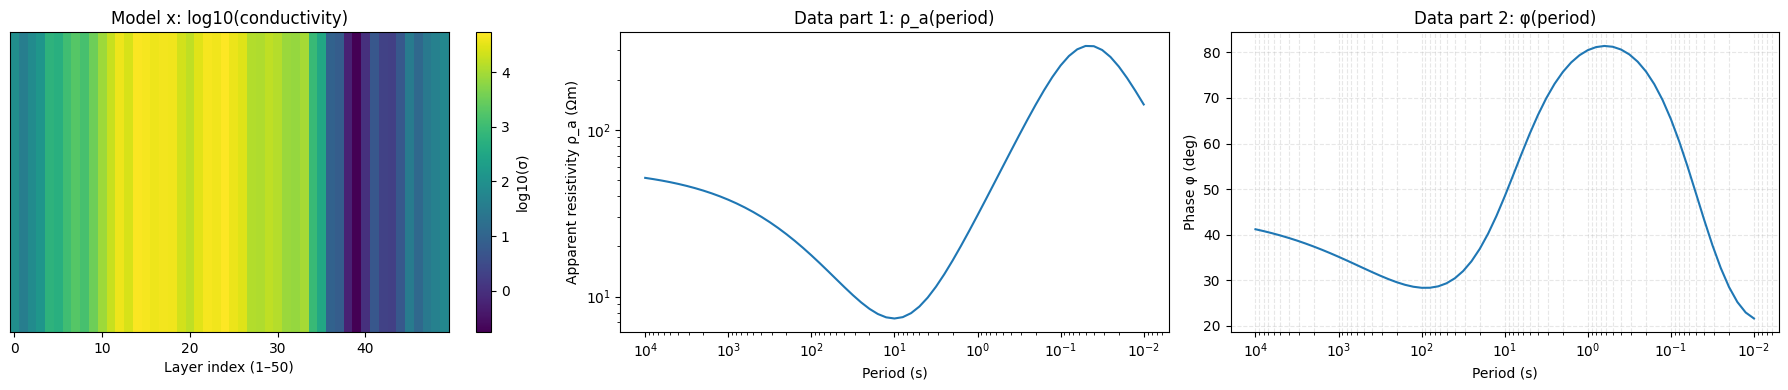

In [5]:
import numpy as np
import matplotlib.pyplot as plt


print("x shape:", x.shape)
print("data_appres shape:", data_appres.shape)
print("data_phase shape:", data_phase.shape)
print("omega_grid shape:", omega_grid.shape)


idx = 0

model_log_sigma = x[idx]
appres = data_appres[idx]
phase  = data_phase[idx]
omega  = omega_grid

freq = omega / (2 * np.pi)           # Hz
period = 1.0 / freq

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
im0 = axes[0].imshow(
    model_log_sigma[None, :],
    aspect='auto',
    cmap='viridis'
)
axes[0].set_title("Model x: log10(conductivity)")
axes[0].set_xlabel("Layer index (1–50)")
axes[0].set_yticks([])
cbar0 = plt.colorbar(im0, ax=axes[0])
cbar0.set_label("log10(σ)")

#-----------------------------
# ρ_a vs period
#-----------------------------
axes[1].loglog(period, appres)
axes[1].invert_xaxis()
axes[1].set_xlabel("Period (s)")
axes[1].set_ylabel("Apparent resistivity ρ_a (Ωm)")
axes[1].set_title("Data part 1: ρ_a(period)")

#-----------------------------
# φ vs period
#-----------------------------
axes[2].semilogx(period, phase)
axes[2].invert_xaxis()
axes[2].set_xlabel("Period (s)")
axes[2].set_ylabel("Phase φ (deg)")
axes[2].set_title("Data part 2: φ(period)")
axes[2].grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# data_appres: (10000, 61)
# data_phase:  (10000, 61)
y_np = np.concatenate([data_appres, data_phase], axis=1)  # (N, 122)
x_np = x                                                  # (N, 50)

print("x shape:", x_np.shape)
print("y shape:", y_np.shape)

# ====== Normalization ======
x_mean = x_np.mean(axis=0, keepdims=True)
x_std  = x_np.std(axis=0, keepdims=True) + 1e-8
y_mean = y_np.mean(axis=0, keepdims=True)
y_std  = y_np.std(axis=0, keepdims=True) + 1e-8

x_norm = (x_np - x_mean) / x_std
y_norm = (y_np - y_mean) / y_std

x_tensor = torch.from_numpy(x_norm).float()
y_tensor = torch.from_numpy(y_norm).float()

dataset = TensorDataset(x_tensor, y_tensor)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


x shape: (10000, 50)
y shape: (10000, 122)
Using device: cpu


In [9]:
x_dim = x_tensor.shape[1]   # 50
y_dim = y_tensor.shape[1]   # 122
z_dim = 64                  # optional

import torch
import torch.nn as nn
import torch.nn.utils as nn_utils

# --------- Generator Resblock ----------
class ResBlockG(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.act(out)

        out = self.fc2(out)
        out = self.bn2(out)

        out = out + residual
        out = self.act(out)
        return out

# --------- Discriminator Resblock ----------
class ResBlockD(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn_utils.spectral_norm(nn.Linear(dim, dim))
        self.fc2 = nn_utils.spectral_norm(nn.Linear(dim, dim))
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        residual = x
        out = self.act(self.fc1(x))
        out = self.fc2(out)
        out = self.act(out + residual)
        return out

# ----------  G(z, y) -> x ----------
class Generator(nn.Module):
    def __init__(self, z_dim, y_dim, x_dim,
                 hidden=512, num_blocks=8):
        """
        hidden: neurons in each hidden layer
        num_blocks: number of residual blocks
        """
        super().__init__()
        in_dim = z_dim + y_dim

        self.fc_in = nn.Linear(in_dim, hidden)
        self.bn_in = nn.BatchNorm1d(hidden)
        self.act = nn.LeakyReLU(0.2, inplace=True)

        blocks = []
        for _ in range(num_blocks):
            blocks.append(ResBlockG(hidden))
        self.blocks = nn.Sequential(*blocks)

        self.fc_out = nn.Linear(hidden, x_dim)

    def forward(self, z, y):
        # z: (B, z_dim), y: (B, y_dim)
        inp = torch.cat([z, y], dim=1)     # (B, z_dim + y_dim)
        h = self.fc_in(inp)
        h = self.bn_in(h)
        h = self.act(h)

        h = self.blocks(h)

        x_fake = self.fc_out(h)
        return x_fake

# ----------  D(x, y) -> logit ----------
class Discriminator(nn.Module):
    def __init__(self, x_dim, y_dim,
                 hidden=512, num_blocks=8):
        super().__init__()
        in_dim = x_dim + y_dim

        self.fc_in = nn_utils.spectral_norm(nn.Linear(in_dim, hidden))
        self.act = nn.LeakyReLU(0.2, inplace=True)

        blocks = []
        for _ in range(num_blocks):
            blocks.append(ResBlockD(hidden))
        self.blocks = nn.Sequential(*blocks)

        self.fc_out = nn_utils.spectral_norm(nn.Linear(hidden, 1))

    def forward(self, x, y):
        # x: (B, x_dim), y: (B, y_dim)
        inp = torch.cat([x, y], dim=1)   # (B, x_dim + y_dim)
        h = self.act(self.fc_in(inp))
        h = self.blocks(h)
        logit = self.fc_out(h)          # (B, 1)
        return logit


G = Generator(z_dim, y_dim, x_dim).to(device)
D = Discriminator(x_dim, y_dim).to(device)


In [10]:
def train_GAN(dataloader,G,D):

  lr = 1e-4
  num_epochs = 200
  beta1 = 0.5
  criterion = nn.BCEWithLogitsLoss()
  optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
  optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

  for epoch in range(num_epochs):
      for i, (x_real, y_cond) in enumerate(dataloader):
          x_real = x_real.to(device)      # (B, 50)
          y_cond = y_cond.to(device)      # (B, 122)
          batch_size = x_real.size(0)

          # =====================
          # 1. update D
          # =====================
          D.zero_grad()

          # true label = 1，fake label = 0
          real_labels = torch.ones(batch_size, 1, device=device)
          fake_labels = torch.zeros(batch_size, 1, device=device)

          # real label distinguish
          out_real_logit = D(x_real, y_cond)
          loss_D_real = criterion(out_real_logit, real_labels)

          # generate fake samples
          z = torch.randn(batch_size, z_dim, device=device)
          x_fake = G(z, y_cond).detach()
          out_fake_logit = D(x_fake, y_cond)
          loss_D_fake = criterion(out_fake_logit, fake_labels)

          loss_D = loss_D_real + loss_D_fake
          loss_D.backward()
          optimizer_D.step()

          # =====================
          # 2. update G
          # =====================
          G.zero_grad()

          z = torch.randn(batch_size, z_dim, device=device)
          x_fake = G(z, y_cond)
          out_fake_logit = D(x_fake, y_cond)
          loss_G = criterion(out_fake_logit, real_labels)

          loss_G.backward()
          optimizer_G.step()

      # print loss
      print(f"Epoch [{epoch+1}/{num_epochs}]  "
            f"Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")


In [10]:
G = Generator(z_dim, y_dim, x_dim,512,12).to(device)
D = Discriminator(x_dim, y_dim,512,12).to(device)
train_GAN(dataloader,G,D)

Epoch [1/200]  Loss_D: 1.4235  Loss_G: 0.7526
Epoch [2/200]  Loss_D: 1.3531  Loss_G: 0.7624
Epoch [3/200]  Loss_D: 1.3978  Loss_G: 0.7647
Epoch [4/200]  Loss_D: 1.3602  Loss_G: 0.7690
Epoch [5/200]  Loss_D: 1.4325  Loss_G: 0.8550
Epoch [6/200]  Loss_D: 1.2457  Loss_G: 0.8802
Epoch [7/200]  Loss_D: 1.0602  Loss_G: 1.2983
Epoch [8/200]  Loss_D: 0.9821  Loss_G: 1.9166
Epoch [9/200]  Loss_D: 1.0801  Loss_G: 1.8660
Epoch [10/200]  Loss_D: 1.0414  Loss_G: 1.4799
Epoch [11/200]  Loss_D: 1.0140  Loss_G: 2.0745
Epoch [12/200]  Loss_D: 0.9232  Loss_G: 1.4173
Epoch [13/200]  Loss_D: 0.8445  Loss_G: 2.5724
Epoch [14/200]  Loss_D: 0.9903  Loss_G: 1.8051
Epoch [15/200]  Loss_D: 1.0545  Loss_G: 1.4125
Epoch [16/200]  Loss_D: 0.8688  Loss_G: 2.8820
Epoch [17/200]  Loss_D: 0.9223  Loss_G: 1.7496
Epoch [18/200]  Loss_D: 0.8284  Loss_G: 1.9279
Epoch [19/200]  Loss_D: 0.9795  Loss_G: 2.6539
Epoch [20/200]  Loss_D: 0.7585  Loss_G: 3.2051
Epoch [21/200]  Loss_D: 0.6802  Loss_G: 2.3746
Epoch [22/200]  Loss_D

In [11]:
import torch

# Define the paths where you want to save your models
model_save_path_G = "./generator_model.pth"
model_save_path_D = "./discriminator_model.pth"
model_save_path_G = "/content/drive/My Drive/generator_model.pth"
model_save_path_D = "/content/drive/My Drive/discriminator_model.pth"

# Save Generator model weights
torch.save(G.state_dict(), model_save_path_G)
print(f"Generator model saved to {model_save_path_G}")

# Save Discriminator model weights
torch.save(D.state_dict(), model_save_path_D)
print(f"Discriminator model saved to {model_save_path_D}")

Generator model saved to /content/drive/My Drive/generator_model.pth
Discriminator model saved to /content/drive/My Drive/discriminator_model.pth


In [11]:
G_loaded = Generator(z_dim, y_dim, x_dim, hidden=512, num_blocks=4).to(device)
D_loaded = Discriminator(x_dim, y_dim, hidden=512, num_blocks=4).to(device)

# Then, load the saved state dictionaries
G_loaded.load_state_dict(torch.load("/content/drive/My Drive/generator_model.pth"))
D_loaded.load_state_dict(torch.load("/content/drive/My Drive/discriminator_model.pth"))

# Set models to evaluation mode if you're not training further
G_loaded.eval()
D_loaded.eval()

print("Models loaded successfully!")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Generated x samples shape: (5, 50)


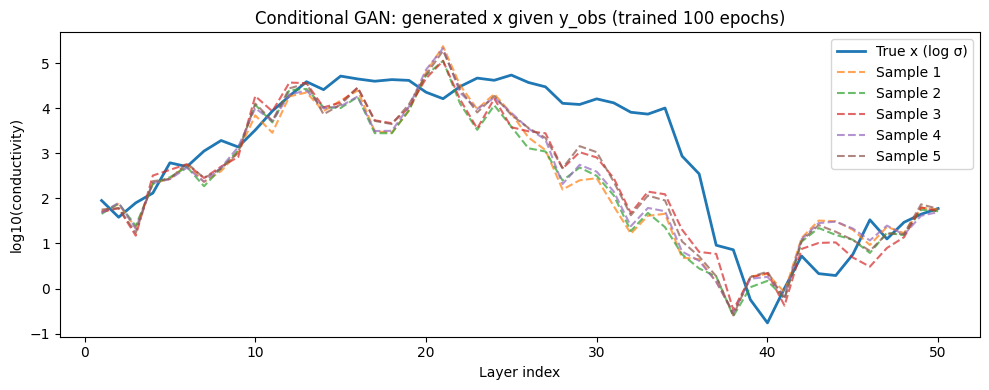

In [12]:
import matplotlib.pyplot as plt

def generate_x_samples(y_obs_np, num_samples=10):
    """
    y_obs_np: (122,) numpy
    return: denormalized (num_samples, 50) numpy
    """
    G.eval()
    with torch.no_grad():
        # normalization
        y_obs_norm = (y_obs_np[None, :] - y_mean) / y_std   # (1, 122)
        y_obs_t = torch.from_numpy(y_obs_norm).float().to(device)

        z = torch.randn(num_samples, z_dim, device=device)
        y_rep = y_obs_t.repeat(num_samples, 1)
        x_fake_norm = G(z, y_rep)          # (num_samples, 50)

        # denormalization
        x_fake = x_fake_norm.cpu().numpy() * x_std + x_mean
    return x_fake

idx = 0
y_obs_example = y_np[idx]          # (122,)
x_true_example = x_np[idx]         # (50,)

x_samples = generate_x_samples(y_obs_example, num_samples=5)

print("Generated x samples shape:", x_samples.shape)  # (5, 50)

# visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
layers = np.arange(1, x_dim + 1)

ax.plot(layers, x_true_example, label="True x (log σ)", linewidth=2)
for i in range(x_samples.shape[0]):
    ax.plot(layers, x_samples[i], alpha=0.7, linestyle='--', label=f"Sample {i+1}")

ax.set_xlabel("Layer index")
ax.set_ylabel("log10(conductivity)")
ax.set_title("Conditional GAN: generated x given y_obs (trained 100 epochs)")
ax.legend()
plt.tight_layout()
plt.show()


In [21]:
G = Generator(z_dim, y_dim, x_dim,512,8).to(device)
D = Discriminator(x_dim, y_dim,512,8).to(device)
train_GAN(dataloader,G,D)

Epoch [1/200]  Loss_D: 1.3534  Loss_G: 0.7373
Epoch [2/200]  Loss_D: 1.3531  Loss_G: 0.7527
Epoch [3/200]  Loss_D: 1.3801  Loss_G: 0.7347
Epoch [4/200]  Loss_D: 1.3717  Loss_G: 0.7008
Epoch [5/200]  Loss_D: 1.3733  Loss_G: 0.7237
Epoch [6/200]  Loss_D: 1.3693  Loss_G: 0.7230
Epoch [7/200]  Loss_D: 1.3777  Loss_G: 0.7246
Epoch [8/200]  Loss_D: 1.3650  Loss_G: 0.7457
Epoch [9/200]  Loss_D: 1.3339  Loss_G: 0.7598
Epoch [10/200]  Loss_D: 1.2611  Loss_G: 0.9065
Epoch [11/200]  Loss_D: 1.2182  Loss_G: 1.2268
Epoch [12/200]  Loss_D: 1.1309  Loss_G: 1.2287
Epoch [13/200]  Loss_D: 0.9134  Loss_G: 1.6488
Epoch [14/200]  Loss_D: 0.9207  Loss_G: 1.5254
Epoch [15/200]  Loss_D: 1.1192  Loss_G: 1.3311
Epoch [16/200]  Loss_D: 1.0978  Loss_G: 1.6513
Epoch [17/200]  Loss_D: 1.1933  Loss_G: 1.1645
Epoch [18/200]  Loss_D: 1.0557  Loss_G: 1.4553
Epoch [19/200]  Loss_D: 0.9150  Loss_G: 1.5768
Epoch [20/200]  Loss_D: 1.2157  Loss_G: 1.4667
Epoch [21/200]  Loss_D: 1.0184  Loss_G: 1.3026
Epoch [22/200]  Loss_D

Generated x samples shape: (5, 50)


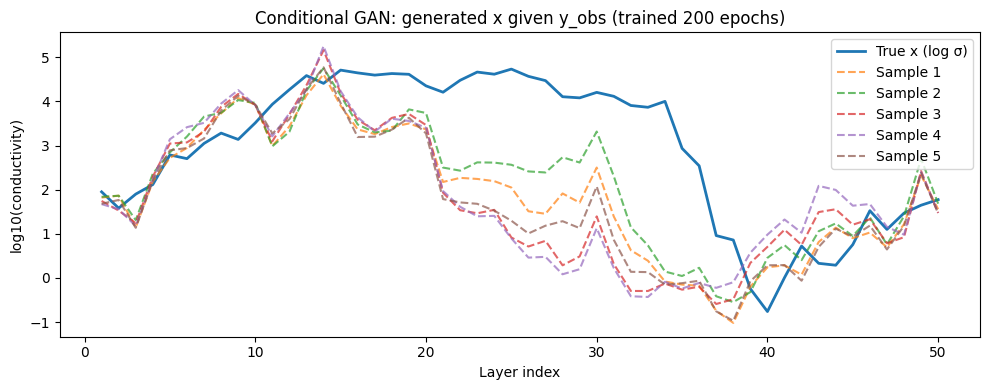

In [24]:
import matplotlib.pyplot as plt

def generate_x_samples(G, y_obs_np, num_samples=10):
    """
    y_obs_np: (122,) numpy
    return: denormalized (num_samples, 50) numpy
    """
    G.eval()
    with torch.no_grad():
        # normalization
        y_obs_norm = (y_obs_np[None, :] - y_mean) / y_std   # (1, 122)
        y_obs_t = torch.from_numpy(y_obs_norm).float().to(device)

        z = torch.randn(num_samples, z_dim, device=device)
        y_rep = y_obs_t.repeat(num_samples, 1)
        x_fake_norm = G(z, y_rep)          # (num_samples, 50)

        # denormalization
        x_fake = x_fake_norm.cpu().numpy() * x_std + x_mean
    return x_fake

idx = 0
y_obs_example = y_np[idx]          # (122,)
x_true_example = x_np[idx]         # (50,)

x_samples = generate_x_samples(G,y_obs_example, num_samples=5)

print("Generated x samples shape:", x_samples.shape)  # (5, 50)

# visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
layers = np.arange(1, x_dim + 1)

ax.plot(layers, x_true_example, label="True x (log σ)", linewidth=2)
for i in range(x_samples.shape[0]):
    ax.plot(layers, x_samples[i], alpha=0.7, linestyle='--', label=f"Sample {i+1}")

ax.set_xlabel("Layer index")
ax.set_ylabel("log10(conductivity)")
ax.set_title("Conditional GAN: generated x given y_obs (trained 200 epochs)")
ax.legend()
plt.tight_layout()
plt.show()

In [26]:
G_10 = Generator(z_dim, y_dim, x_dim,512,10).to(device)
D = Discriminator(x_dim, y_dim,512,8).to(device)
train_GAN(dataloader,G_10,D)

Epoch [1/200]  Loss_D: 1.3759  Loss_G: 0.7163
Epoch [2/200]  Loss_D: 1.3601  Loss_G: 0.7349
Epoch [3/200]  Loss_D: 1.3680  Loss_G: 0.7504
Epoch [4/200]  Loss_D: 1.3782  Loss_G: 0.7116
Epoch [5/200]  Loss_D: 1.3796  Loss_G: 0.7275
Epoch [6/200]  Loss_D: 1.3666  Loss_G: 0.7390
Epoch [7/200]  Loss_D: 1.3744  Loss_G: 0.7216
Epoch [8/200]  Loss_D: 1.3028  Loss_G: 0.8624
Epoch [9/200]  Loss_D: 1.2635  Loss_G: 1.0382
Epoch [10/200]  Loss_D: 1.2842  Loss_G: 1.0272
Epoch [11/200]  Loss_D: 1.0752  Loss_G: 1.3175
Epoch [12/200]  Loss_D: 1.0275  Loss_G: 1.7222
Epoch [13/200]  Loss_D: 1.2161  Loss_G: 1.2995
Epoch [14/200]  Loss_D: 1.2502  Loss_G: 0.9890
Epoch [15/200]  Loss_D: 0.9884  Loss_G: 1.6162
Epoch [16/200]  Loss_D: 0.9696  Loss_G: 1.5249
Epoch [17/200]  Loss_D: 1.0009  Loss_G: 1.4606
Epoch [18/200]  Loss_D: 1.1601  Loss_G: 1.4393
Epoch [19/200]  Loss_D: 1.0073  Loss_G: 1.9215
Epoch [20/200]  Loss_D: 1.4081  Loss_G: 0.9405
Epoch [21/200]  Loss_D: 1.1430  Loss_G: 1.2490
Epoch [22/200]  Loss_D

Generated x samples shape: (5, 50)


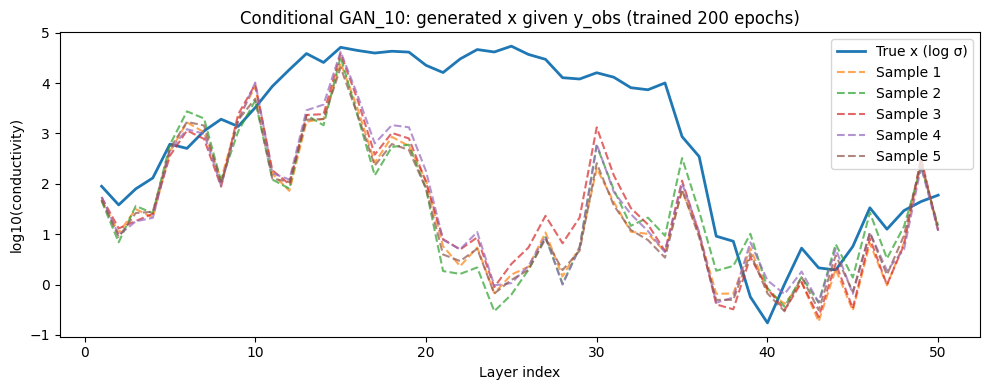

In [27]:
idx = 0
y_obs_example = y_np[idx]          # (122,)
x_true_example = x_np[idx]         # (50,)

x_samples = generate_x_samples(G,y_obs_example, num_samples=5)

print("Generated x samples shape:", x_samples.shape)  # (5, 50)

# visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
layers = np.arange(1, x_dim + 1)

ax.plot(layers, x_true_example, label="True x (log σ)", linewidth=2)
for i in range(x_samples.shape[0]):
    ax.plot(layers, x_samples[i], alpha=0.7, linestyle='--', label=f"Sample {i+1}")

ax.set_xlabel("Layer index")
ax.set_ylabel("log10(conductivity)")
ax.set_title("Conditional GAN_10: generated x given y_obs (trained 200 epochs)")
ax.legend()
plt.tight_layout()
plt.show()

Generated x samples shape: (5, 50)


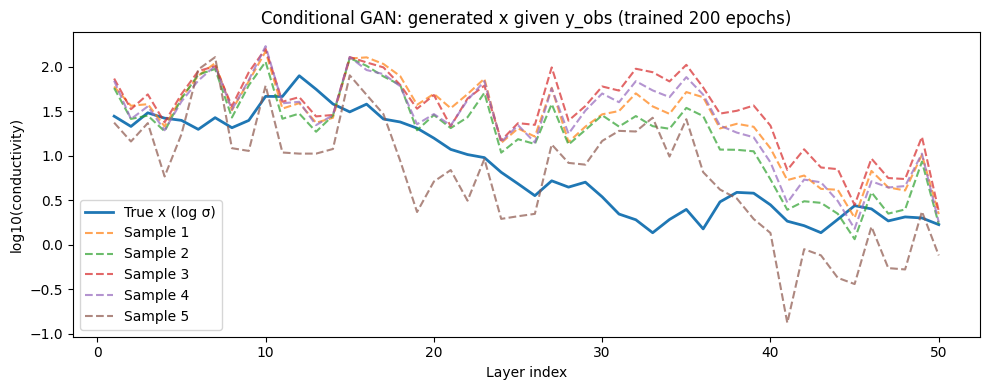

In [28]:
idx = 2
y_obs_example = y_np[idx]          # (122,)
x_true_example = x_np[idx]         # (50,)

x_samples = generate_x_samples(G,y_obs_example, num_samples=5)

print("Generated x samples shape:", x_samples.shape)  # (5, 50)

# visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
layers = np.arange(1, x_dim + 1)

ax.plot(layers, x_true_example, label="True x (log σ)", linewidth=2)
for i in range(x_samples.shape[0]):
    ax.plot(layers, x_samples[i], alpha=0.7, linestyle='--', label=f"Sample {i+1}")

ax.set_xlabel("Layer index")
ax.set_ylabel("log10(conductivity)")
ax.set_title("Conditional GAN: generated x given y_obs (trained 200 epochs)")
ax.legend()
plt.tight_layout()
plt.show()

Generated x samples shape: (5, 50)


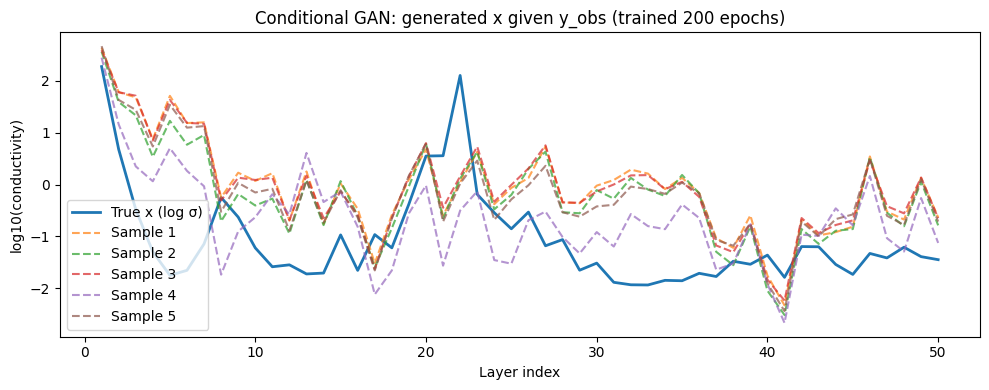

In [29]:
idx = 5
y_obs_example = y_np[idx]          # (122,)
x_true_example = x_np[idx]         # (50,)

x_samples = generate_x_samples(G,y_obs_example, num_samples=5)

print("Generated x samples shape:", x_samples.shape)  # (5, 50)

# visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
layers = np.arange(1, x_dim + 1)

ax.plot(layers, x_true_example, label="True x (log σ)", linewidth=2)
for i in range(x_samples.shape[0]):
    ax.plot(layers, x_samples[i], alpha=0.7, linestyle='--', label=f"Sample {i+1}")

ax.set_xlabel("Layer index")
ax.set_ylabel("log10(conductivity)")
ax.set_title("Conditional GAN: generated x given y_obs (trained 200 epochs)")
ax.legend()
plt.tight_layout()
plt.show()

Epoch 1/200  Step 20/78  D: 0.9878  G_adv: 0.3520  G_phy: 85920424.0000
Epoch 1/200  Step 40/78  D: 0.1782  G_adv: 6.5655  G_phy: 35899724.0000
Epoch 1/200  Step 60/78  D: 0.4598  G_adv: 8.4939  G_phy: 44778864.0000
==> Epoch 1 done
Epoch 2/200  Step 20/78  D: 0.4918  G_adv: 6.7247  G_phy: 80637464.0000
Epoch 2/200  Step 40/78  D: 0.4083  G_adv: 6.5810  G_phy: 33061068.0000
Epoch 2/200  Step 60/78  D: 0.1757  G_adv: 7.1982  G_phy: 21802278.0000
==> Epoch 2 done
Epoch 3/200  Step 20/78  D: 0.2685  G_adv: 6.6095  G_phy: 14306088.0000
Epoch 3/200  Step 40/78  D: 0.1011  G_adv: 6.9163  G_phy: 59110020.0000
Epoch 3/200  Step 60/78  D: 0.2132  G_adv: 6.4868  G_phy: 46042752.0000
==> Epoch 3 done
Epoch 4/200  Step 20/78  D: 0.2484  G_adv: 5.2005  G_phy: 48320432.0000
Epoch 4/200  Step 40/78  D: 0.2385  G_adv: 8.2060  G_phy: 126713664.0000
Epoch 4/200  Step 60/78  D: 0.1421  G_adv: 6.6943  G_phy: 134329728.0000
==> Epoch 4 done
Epoch 5/200  Step 20/78  D: 0.2135  G_adv: 7.6930  G_phy: 34427876

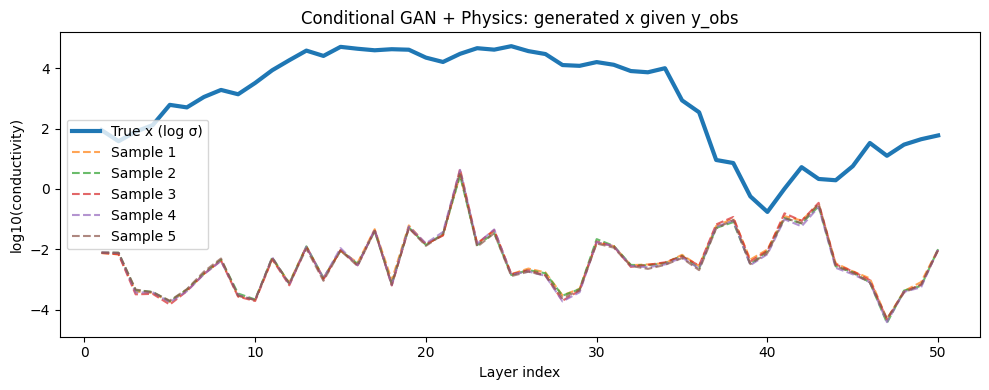

In [40]:
import torch.nn.functional as F
x_mean_t = torch.from_numpy(x_mean).float().to(device)  # (1, 50)
x_std_t  = torch.from_numpy(x_std ).float().to(device)
y_mean_t = torch.from_numpy(y_mean).float().to(device)  # (1, 122)
y_std_t  = torch.from_numpy(y_std ).float().to(device)

omega_t = torch.from_numpy(omega_grid).float().to(device)  # (61,)

# simple layer thickness, replace with real h if you have it
h_np = np.ones(x_dim, dtype=np.float32) * 100.0
h_t  = torch.from_numpy(h_np).float().to(device)  # (50,)

# ----------------- 1D MT forward, batched -----------------
MU_0 = 4 * np.pi * 1e-7
EPS  = 1e-12

def f_batch(rho_batch, h, omega, mu=MU_0):
    """
    rho_batch: (B, N_layers)
    h:        (N_layers,)
    omega:    (N_omega,)
    return:   (B, N_omega, 2)  [rho_a, phi]
    """
    device = rho_batch.device
    omega = omega.to(device=device, dtype=torch.float32)
    h     = h.to(device=device,     dtype=torch.float32)

    B, N_layers = rho_batch.shape
    N_omega     = omega.shape[0]

    # clamp rho to avoid zero / negative
    rho_batch = torch.clamp(rho_batch, min=1e-4, max=1e4)

    rho_mat = rho_batch[:, None, :].expand(-1, N_omega, -1)   # (B, N_omega, N_layers)
    rho_c   = rho_mat.to(torch.complex64)

    omega_c = omega.to(torch.complex64)[None, :, None]        # (1, N_omega, 1)
    numerator = -1j * mu * omega_c                            # (1, N_omega, 1)

    k = torch.sqrt(numerator / (rho_c + EPS))                 # (B, N_omega, N_layers)

    R_next = None
    for i in range(N_layers - 2, -1, -1):
        k_i   = k[:, :, i]                                    # (B, N_omega)
        k_ip1 = k[:, :, i+1]                                  # (B, N_omega)
        denom = k_i + k_ip1
        denom = denom + EPS
        r_i   = (k_i - k_ip1) / denom
        h_i   = h[i]

        if R_next is None:
            R_current = r_i * torch.exp(-1j * k_i * h_i)
        else:
            h_ip1 = h[i+1]
            R_propagated = R_next * torch.exp(-1j * k_ip1 * h_ip1)
            denom2 = 1 + r_i * R_propagated
            denom2 = denom2 + EPS
            R_int  = (r_i + R_propagated) / denom2
            R_current = R_int * torch.exp(-1j * k_i * h_i)

        R_next = R_current

    R_surface = R_next                                        # (B, N_omega)

    k0 = k[:, :, 0]
    omega_c1 = omega.to(torch.complex64)[None, :]             # (1, N_omega)
    Z1 = (mu * omega_c1) / (k0 + EPS)                         # (B, N_omega)
    prop_factor_h0 = torch.exp(-1j * k0 * h[0])               # (B, N_omega)

    denomZ = R_surface * prop_factor_h0 - 1
    denomZ = denomZ + EPS
    Z = -Z1 * (R_surface * prop_factor_h0 + 1) / denomZ       # (B, N_omega)

    omega_b = omega[None, :]                                  # (1, N_omega)
    rho_a = (1.0 / (omega_b + EPS)) * (1.0 / mu) * torch.abs(Z)**2  # (B, N_omega)
    phi   = (180.0 / np.pi) * torch.atan2(Z.imag, Z.real)     # (B, N_omega)

    # clamp physics outputs to reasonable range
    rho_a = torch.clamp(rho_a, 1e-2, 1e6)
    phi   = torch.clamp(phi, -90.0, 90.0)

    out = torch.stack((rho_a, phi), dim=2)                    # (B, N_omega, 2)
    out = torch.nan_to_num(out, nan=0.0, posinf=1e6, neginf=-1e6)
    return out

def forward_mt_from_x_norm_batch(x_norm_batch,
                                 x_mean_t, x_std_t,
                                 h_t, omega_t):
    """
    x_norm_batch: (B, 50)
    return y_pred_phys: (B, 122)
    """
    x_log_sigma   = x_norm_batch * x_std_t + x_mean_t         # (B, 50)
    # clamp log_sigma to keep sigma in [1e-2, 1e4]
    x_log_sigma   = torch.clamp(x_log_sigma, -2.0, 4.0)

    sigma_layers  = torch.pow(10.0, x_log_sigma)              # (B, 50)
    rho_layers    = 1.0 / sigma_layers                        # (B, 50)

    out = f_batch(rho_layers, h_t, omega_t)                   # (B, 61, 2)
    rho_a = out[:, :, 0]                                      # (B, 61)
    phi   = out[:, :, 1]                                      # (B, 61)

    y_pred_phys = torch.cat([rho_a, phi], dim=1)              # (B, 122)
    y_pred_phys = torch.nan_to_num(y_pred_phys, nan=0.0, posinf=1e6, neginf=-1e6)
    return y_pred_phys

# ----------------- Residual blocks & GAN -----------------
class ResBlockG(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.act(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = out + residual
        out = self.act(out)
        return out

class ResBlockD(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn_utils.spectral_norm(nn.Linear(dim, dim))
        self.fc2 = nn_utils.spectral_norm(nn.Linear(dim, dim))
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        residual = x
        out = self.act(self.fc1(x))
        out = self.fc2(out)
        out = self.act(out + residual)
        return out

class Generator(nn.Module):
    def __init__(self, z_dim, y_dim, x_dim, hidden=512, num_blocks=4):
        super().__init__()
        in_dim = z_dim + y_dim
        self.fc_in = nn.Linear(in_dim, hidden)
        self.bn_in = nn.BatchNorm1d(hidden)
        self.act   = nn.LeakyReLU(0.2)
        blocks = [ResBlockG(hidden) for _ in range(num_blocks)]
        self.blocks = nn.Sequential(*blocks)
        self.fc_out = nn.Linear(hidden, x_dim)

    def forward(self, z, y):
        inp = torch.cat([z, y], dim=1)
        h = self.fc_in(inp)
        h = self.bn_in(h)
        h = self.act(h)
        h = self.blocks(h)
        x_fake = self.fc_out(h)
        return x_fake

class Discriminator(nn.Module):
    def __init__(self, x_dim, y_dim, hidden=512, num_blocks=4):
        super().__init__()
        in_dim = x_dim + y_dim
        self.fc_in = nn_utils.spectral_norm(nn.Linear(in_dim, hidden))
        self.act   = nn.LeakyReLU(0.2)
        blocks = [ResBlockD(hidden) for _ in range(num_blocks)]
        self.blocks = nn.Sequential(*blocks)
        self.fc_out = nn_utils.spectral_norm(nn.Linear(hidden, 1))

    def forward(self, x, y):
        inp = torch.cat([x, y], dim=1)
        h = self.act(self.fc_in(inp))
        h = self.blocks(h)
        logit = self.fc_out(h)
        return logit

# ----------------- Init models & optimizers -----------------
z_dim = 64

G = Generator(z_dim, y_dim, x_dim, hidden=512, num_blocks=16).to(device)
D = Discriminator(x_dim, y_dim, hidden=512, num_blocks=12).to(device)

lr = 2e-4
beta1 = 0.5
num_epochs = 200
lambda_phy = 1e-2   # smaller physics weight to start

criterion_adv = nn.BCEWithLogitsLoss()
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

# ----------------- Training loop -----------------
for epoch in range(num_epochs):
    for step, (x_real, y_cond) in enumerate(dataloader, start=1):
        x_real = x_real.to(device)
        y_cond = y_cond.to(device)
        batch_size = x_real.size(0)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # --- update D ---
        optimizer_D.zero_grad()

        out_real = D(x_real, y_cond)
        loss_D_real = criterion_adv(out_real, real_labels)

        z = torch.randn(batch_size, z_dim, device=device)
        with torch.no_grad():
            x_fake_for_D = G(z, y_cond)
        out_fake = D(x_fake_for_D, y_cond)
        loss_D_fake = criterion_adv(out_fake, fake_labels)

        loss_D = loss_D_real + loss_D_fake

        if torch.isnan(loss_D).any() or torch.isinf(loss_D).any():
            print("NaN/Inf in D loss, skip batch")
        else:
            loss_D.backward()
            nn.utils.clip_grad_norm_(D.parameters(), max_norm=10.0)
            optimizer_D.step()

        # --- update G (adv + physics) ---
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, z_dim, device=device)
        x_fake = G(z, y_cond)

        out_fake_for_G = D(x_fake, y_cond)
        loss_G_adv = criterion_adv(out_fake_for_G, real_labels)

        y_obs_phys = y_cond * y_std_t + y_mean_t
        y_pred_phys = forward_mt_from_x_norm_batch(
            x_fake, x_mean_t, x_std_t, h_t, omega_t
        )

        loss_G_phy = F.mse_loss(y_pred_phys, y_obs_phys)
        loss_G = loss_G_adv + lambda_phy * loss_G_phy

        if torch.isnan(loss_G).any() or torch.isinf(loss_G).any():
            print("NaN/Inf in G loss, skip batch")
        else:
            loss_G.backward()
            nn.utils.clip_grad_norm_(G.parameters(), max_norm=10.0)
            optimizer_G.step()

        if step % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}  "
                  f"Step {step}/{len(dataloader)}  "
                  f"D: {loss_D.item():.4f}  "
                  f"G_adv: {loss_G_adv.item():.4f}  "
                  f"G_phy: {loss_G_phy.item():.4f}")

    print(f"==> Epoch {epoch+1} done")

print("Training done.")

# ----------------- Sampling and simple visualization -----------------
idx = 5
y_obs_example = y_np[idx]       # (122,) physical scale
x_true_example = x[idx]      # (50,)  physical log(conductivity)

def generate_x_samples(G,y_obs_np, num_samples=5):
    G.eval()
    with torch.no_grad():
        y_obs_norm = (y_obs_np[None, :] - y_mean) / y_std      # (1, 122)
        y_obs_t = torch.from_numpy(y_obs_norm).float().to(device)
        z = torch.randn(num_samples, z_dim, device=device)
        y_rep = y_obs_t.repeat(num_samples, 1)
        x_fake_norm = G(z, y_rep)                              # (num_samples, 50)
        x_fake = x_fake_norm * x_std_t + x_mean_t              # back to log σ
        x_fake = x_fake.cpu().numpy()
    return x_fake

x_samples = generate_x_samples(G, y_obs_example, num_samples=5)

layers = np.arange(1, x_dim + 1)
plt.figure(figsize=(10, 4))
plt.plot(layers, x_true_example, label="True x (log σ)", linewidth=3)
for i in range(x_samples.shape[0]):
    plt.plot(layers, x_samples[i], '--', alpha=0.7, label=f"Sample {i+1}")
plt.xlabel("Layer index")
plt.ylabel("log10(conductivity)")
plt.title("Conditional GAN + Physics: generated x given y_obs")
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
idx = 1
y_obs_example = y_np[idx]       # (122,) physical scale
x_true_example = x[idx]      # (50,)  physical log(conductivity)

def generate_x_samples(G,y_obs_np, num_samples=5):
    G.eval()
    with torch.no_grad():
        y_obs_norm = (y_obs_np[None, :] - y_mean) / y_std      # (1, 122)
        y_obs_t = torch.from_numpy(y_obs_norm).float().to(device)
        z = torch.randn(num_samples, z_dim, device=device)
        y_rep = y_obs_t.repeat(num_samples, 1)
        x_fake_norm = G(z, y_rep)                              # (num_samples, 50)
        x_fake = x_fake_norm * x_std_t + x_mean_t              # back to log σ
        x_fake = x_fake.cpu().numpy()
    return x_fake

x_samples = generate_x_samples(G, y_obs_example, num_samples=5)

layers = np.arange(1, x_dim + 1)
plt.figure(figsize=(10, 4))
plt.plot(layers, x_true_example, label="True x (log σ)", linewidth=3)
for i in range(x_samples.shape[0]):
    plt.plot(layers, x_samples[i], '--', alpha=0.7, label=f"Sample {i+1}")
plt.xlabel("Layer index")
plt.ylabel("log10(conductivity)")
plt.title("Conditional GAN + Physics: generated x given y_obs")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'y_np' is not defined

In [ ]:
# pick one sample
i = 0
x_i      = torch.from_numpy(x[i]).float().to(device)      # (50,) original log values from file
y_i_app  = torch.from_numpy(data_appres[i]).float().to(device)  # (61,)
y_i_phi  = torch.from_numpy(data_phase[i]).float().to(device)   # (61,)
y_i_true = torch.cat([y_i_app, y_i_phi], dim=0)           # (122,)

# (A) assume x = log10(σ)
def forward_from_log_sigma(x_log_sigma_1d):
    sigma = torch.pow(10.0, x_log_sigma_1d)   # (50,)
    rho   = 1.0 / sigma                       # (50,)
    out   = f_batch(rho[None, :], h_t, omega_t)[0]  # (61, 2)
    rho_a = out[:, 0]
    phi   = out[:, 1]
    return torch.cat([rho_a, phi], dim=0)

# (B) assume x = log10(ρ)
def forward_from_log_rho(x_log_rho_1d):
    rho   = torch.pow(10.0, x_log_rho_1d)     # (50,)
    out   = f_batch(rho[None, :], h_t, omega_t)[0]  # (61, 2)
    rho_a = out[:, 0]
    phi   = out[:, 1]
    return torch.cat([rho_a, phi], dim=0)

with torch.no_grad():
    y_pred_A = forward_from_log_sigma(x_i)
    y_pred_B = forward_from_log_rho  (x_i)

    err_A = torch.mean((y_pred_A - y_i_true)**2).item()
    err_B = torch.mean((y_pred_B - y_i_true)**2).item()

print("MSE if x = log10(σ):", err_A)
print("MSE if x = log10(ρ):", err_B)